# Multi-layer Perceptron - Classification of Diabetics
#!pip3 install torch

To predict if a person is likely to be diabetic or not
Data used is for illustration only

A Single Layer Perceptron is not able to classify datasets that are not linearly separable, hence we use a multi-layer perceptron.

In [1]:
# Jupyter notebook commands
%config IPCompleter.greedy=True # enable intellisense by using 'tab' key

# Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import datasets

# Check for Cuda or CPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Additional Helper Functions

### Plotting Functions

In [4]:
class DataPlot():
    def __init__(self):
        plt.style.use('ggplot')        
        
    def plot_Size(self, width, height):
        self.fig=plt.figure(figsize=(width,height))            
        
    def xLim(self,xMin, xMax):
        plt.xlim(-2.0, 2.0)        
        
    def yLim(self,yMin, yMax):
        plt.ylim(yMin,yMax)        
    
    def plot_show(self):        
        plt.show()
        
    def plot_point(self,x,y,extra):
        plt.plot(x,y,extra)

    def plot_scatter(self, X, y, title):                    
        plt.title(title)        
        plt.xlabel("x1 - Age")
        plt.ylabel("x2 - Blood Sugar Levels",rotation=90)
        plt.scatter(X[y==0, 0], X[y==0, 1], c='g',label="Class 0 - No Diabetic") # plot all points where y == 0 (both col 0 and col 1 in X in Red)
        plt.scatter(X[y==1, 0], X[y==1, 1], c='r', label="Class 1 -Likely Diabetic") # plot all points where y == 0 (both col 0 and col 1 in X in Green)        
        plt.legend(loc="upper right")
        plt.xlim(-2.0, 2.0)
        plt.ylim(-2.0, 2.0)
        
    def plot_lineChart(self,X,y,title, x_label, y_label):
        plt.title(title)
        plt.plot(X,y)
        plt.xlabel(x_label)
        plt.ylabel(y_label,rotation=90)
              
    def plot_line2D(self,x1,y1,x2,y2):
        plt.plot([x1,x2],[y1,y2])
        
    def plot_fit2DLine(self, model):        
        w, b = model.get_params()
        b = b.item() # convert from tensor to float        
        w1,w2 = w.view(2) 
        w1 = w1.item()
        w2 = w2.item()
        
        # linear equation
        # w1x1 + w2x2 + b =0
        # w2x2 = -w1x1 - b = -(w1x1+b)
        # x2   = -(w1x1 + b)/w2 # equation of line in format, y=mx + c
        x1 = np.array([-2.0,2.0]) # this is the limits of this specific data plot
        x2 = -(w1 * x1 + b)/w2
        
        plt.plot(x1,x2,'b')
        
        #self.plot_line2D(x1,y1,x2,y2)        
        
        
    def plot_Decision_Boundary(self,model,X,y):        
        # to make the graph look nicer, we add extra space by adding '-1' to min() and '+1' to max(), 
        # else there is a empty space in the graph
        # empty border
        x_span = np.linspace(min(X[:,0])-1, max(X[:,0])+1)
        y_span = np.linspace(min(X[:,1])-1, max(X[:,1])+1)

        # https://stackoverflow.com/questions/36013063/what-is-the-purpose-of-meshgrid-in-python-numpy
        # both xx and yy are 2d arrays
        xx,yy = np.meshgrid(x_span, y_span)    
        # flatten the 2d arrays into 1d, then vertically concatenate into var grid
        #np.c_[xx.ravel(),yy.ravel()]
        grid = torch.Tensor(np.c_[xx.ravel(), yy.ravel()]).to(device)

        # predict the class of each point in the grid
        predictions = model.forward(grid)  
        
        # and reshape the prediction results so that they are linked to their
        # appropriate coordinate counterparts
        # use detach() to exclude any sub graphs from gradient computation
        # z contains the magnitute of the probablility and each corresponding coordinate
        z = predictions.view(xx.shape).detach().cpu().numpy()
        
        # use plt.contour, allows shape of our prediction data to be consistent with the
        # 50x50 shape of our graph such that each coordinate in the graph would be associated
        # with a corresponding prediction.
        # plot distinct contour zones, each of which represents a distinct probability level
        # https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contourf.html
        plt.contourf(xx,yy,z)



# Data

### Create / Import Data


In [5]:
# instantiate Plotting helper functions
dataPlot = DataPlot()

# Make Blobs
# https://docs.w3cub.com/scikit_learn/modules/generated/sklearn.datasets.make_blobs/

n_pts = 600

# "Fake data" of people who have and did not have diabetics (for illustration only)
# X consists of 2 features: x1 - age and X2 - blood glucose levels
# y consists of either 1 or 0 (diabetic or not diabetic)

# noise = 0 will give perfect circles, factor = 0.25 -> diameter of inner circle is 25% of the outer circle
X, y = datasets.make_circles(n_samples = n_pts,random_state=88, noise=0.1905, factor=0.22)

# Convert to Tensor
X_data = torch.Tensor(X).to(device)
y_data = torch.Tensor(y.reshape(y.shape[0], 1)).to(device)


print("X.shape is: {}".format(X.shape))
print("y.shape is: {}\n".format(y.shape))
print("X_data.shape is: {}".format(X_data.size()))
print("y_data.shape is: {}".format(y_data.size()))
print("\nFirst 10 rows of dataset X are")
print("x-Axis values,   y-Axis values")
print("=============,   =============")
print(X[0:10])
print("\nFirst 10 rows of labeled dataset y are:\n=======================\n{}".format(y[0:10]))
print("\nset(y) returns: {}".format(set(y)))

X.shape is: (600, 2)
y.shape is: (600,)

X_data.shape is: torch.Size([600, 2])
y_data.shape is: torch.Size([600, 1])

First 10 rows of dataset X are
x-Axis values,   y-Axis values
=============,   =============
[[-0.02152036 -0.34073935]
 [-0.48339295 -0.00563747]
 [ 0.60474321 -0.84316279]
 [-0.04561595 -0.08357394]
 [-0.01856618 -0.86273335]
 [-0.08539073  0.72111575]
 [ 0.17988045 -0.17883949]
 [-0.56886001 -0.7441239 ]
 [-0.09241404  0.24530195]
 [ 0.6720616  -1.12628248]]

First 10 rows of labeled dataset y are:
[1 1 0 1 0 0 1 0 1 0]

set(y) returns: {0, 1}


### Explore Data

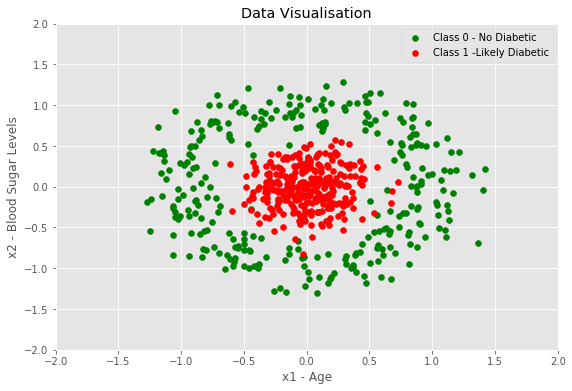

In [6]:
dataPlot.plot_Size(9,6)
dataPlot.plot_scatter(X,y,"Data Visualisation")

dataPlot.plot_show()

# Multilayer Perceptron (MLP) - Classification
a MLP has
* One input layer
* more than 1 hidden layer
* One output layer


In [7]:
class Model(nn.Module):
    def __init__(self, input_size, h1, output_size):
        super().__init__()         
        self.linear_01 = nn.Linear(input_size, h1)     
        self.linear_02 = nn.Linear(h1, output_size)     
        
   
    def get_params(self):
        [w, b] = self.parameters()        
        return [w,b]
    
    def forward(self, x):        
        x = torch.sigmoid(self.linear_01(x)) # from input layer to the output of the first hidden layer
        x = torch.sigmoid(self.linear_02(x)) # from the output of the first hidden layer to the output of the output layer
        
        # the output of the output layer is then used by .predict() to predict the class.
        return x    
        
    def train(self, epochs, updateRate, lr=0.01):
        print("starting training")
        
        # Binary Cross Entrophy
        self.criterion = nn.BCELoss() 
        
        # optimizer sgd = stochastic gradient descent
        self.optimizer = torch.optim.Adam(model.parameters(), lr) # model param and learning rate
        
        # We first compute the error of our model based on binay cross entropy criterion
        # then we take its derivative and by substracting the derivative from the weights and bias,
        # it updates them in the direction of the least error, descending with the gradient
        
        #epochs = epochs
        losses = []

        for i in range(epochs):                       
            y_pred = self.forward(X_data)
            loss = self.criterion(y_pred, y_data)   
            
            if(i%updateRate == 0): # print once every 50 epochs
                print("epoch:", i, "loss:", loss.item())            
            losses.append(loss.item())
                        
            self.optimizer.zero_grad() # set gradient back to 0 or it will accumulate
            loss.backward() 
            self.optimizer.step()   
        
        return losses
    
    def predict(self, x):
        prediction = []
        pred = self.forward(x)       
        
        # append the value from forward propagation
        prediction.append(pred.item()) 
        
        # append the prediction from the value
        if pred >= 0.5:
            prediction.append(1)            
        else:
            prediction.append(0)
        
        return prediction

# Instantiate Model

In [8]:
torch.manual_seed(50) # set random seed

# input_size: 2 nodes, h1: 4 nodes, output_size: 1 node
# too few nodes may lead to poor fit or not fit, too many nodes may lead to overfitting and poor generalisation
model = Model(2, 4, 1).to(device) 

print(list(model.parameters()))
print()

#print("After conversion to Numpy Array")
# to convert torch.size to a numpy array, the usual .numpy() doesn't work, need to .detach() first.
# also, I chose to flatten first using .view(w.numel), but depending on use case, this may not be needed.

#w,b = model.parameters()
#w = np.array(w.view(w.numel()).detach().cpu().numpy()) # need to do .cpu() 1st to take the tensor out of GPU
# otherwise,"can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.""

#for i in range(len(w)):
#    print('weight w{} = \b {:0.3f}'.format(i,w[i]))

#print('bias b = \b {:0.3f}'.format(b.item())) # .item() to get a python float value


[Parameter containing:
tensor([[ 0.1669, -0.6100],
        [-0.1566, -0.6500],
        [-0.1395, -0.5032],
        [-0.0559, -0.0174]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 0.1310,  0.6553, -0.5332, -0.1347], device='cuda:0',
       requires_grad=True), Parameter containing:
tensor([[-0.0015,  0.4987,  0.1049,  0.0229]], device='cuda:0',
       requires_grad=True), Parameter containing:
tensor([0.1974], device='cuda:0', requires_grad=True)]



### View Current Fit to Data

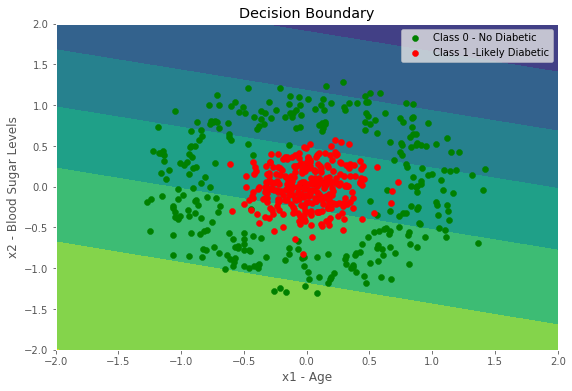

As the initial weights and bias are randomly initialised, we can see, the initial fit is not good at all.



In [9]:
del dataPlot
dataPlot = DataPlot()

dataPlot.plot_Size(9,6)
dataPlot.plot_Decision_Boundary(model,X,y)
dataPlot.xLim(-1.5,1.5)
dataPlot.yLim(-1.5,1.5)    
dataPlot.plot_scatter(X,y,"Decision Boundary")

dataPlot.plot_show()

print("As the initial weights and bias are randomly initialised, we can see, the initial fit is not good at all.\n")

# Train Model

In [10]:
epochs = 800
lr = 0.1
losses = model.train(epochs=epochs, updateRate=30, lr=lr)


starting training
epoch: 0 loss: 0.7328229546546936
epoch: 30 loss: 0.5562905669212341
epoch: 60 loss: 0.1900656670331955
epoch: 90 loss: 0.10685567557811737
epoch: 120 loss: 0.08042344450950623
epoch: 150 loss: 0.06963985413312912
epoch: 180 loss: 0.06363578885793686
epoch: 210 loss: 0.059486955404281616
epoch: 240 loss: 0.05625118315219879
epoch: 270 loss: 0.05359745770692825
epoch: 300 loss: 0.051410332322120667
epoch: 330 loss: 0.0496266707777977
epoch: 360 loss: 0.04816310480237007
epoch: 390 loss: 0.04694484546780586
epoch: 420 loss: 0.04591687023639679
epoch: 450 loss: 0.04503874480724335
epoch: 480 loss: 0.04428009316325188
epoch: 510 loss: 0.04361781105399132
epoch: 540 loss: 0.043034154921770096
epoch: 570 loss: 0.0425153449177742
epoch: 600 loss: 0.04205058142542839
epoch: 630 loss: 0.041631270200014114
epoch: 660 loss: 0.04125054180622101
epoch: 690 loss: 0.04090286046266556
epoch: 720 loss: 0.04058367386460304
epoch: 750 loss: 0.040289223194122314
epoch: 780 loss: 0.040016

# Plot Loss 

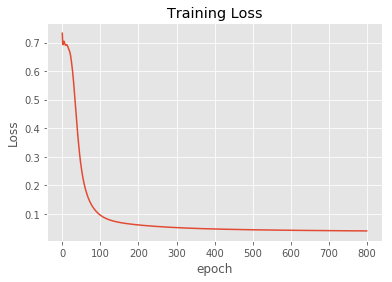

Optimal Epoch is around 120.


In [14]:
dataPlot.plot_lineChart(range(epochs),losses,"Training Loss","epoch","Loss")
dataPlot.plot_show()

print("Optimal Epoch is around 120.")

# plot decision boundary

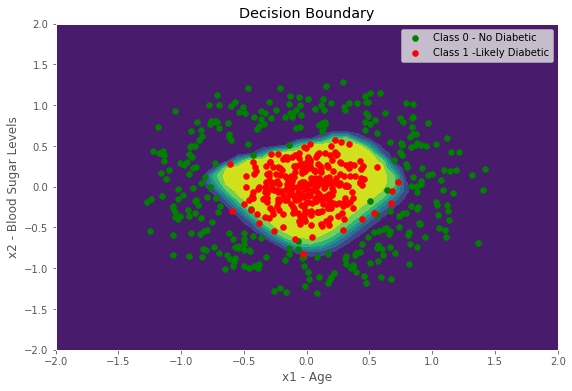

In [12]:
del dataPlot
dataPlot = DataPlot()

dataPlot.plot_Size(9,6)
dataPlot.plot_Decision_Boundary(model,X,y)
dataPlot.xLim(-1.5,1.5)
dataPlot.yLim(-1.5,1.5)    
dataPlot.plot_scatter(X,y,"Decision Boundary")

dataPlot.plot_show()

# Predict

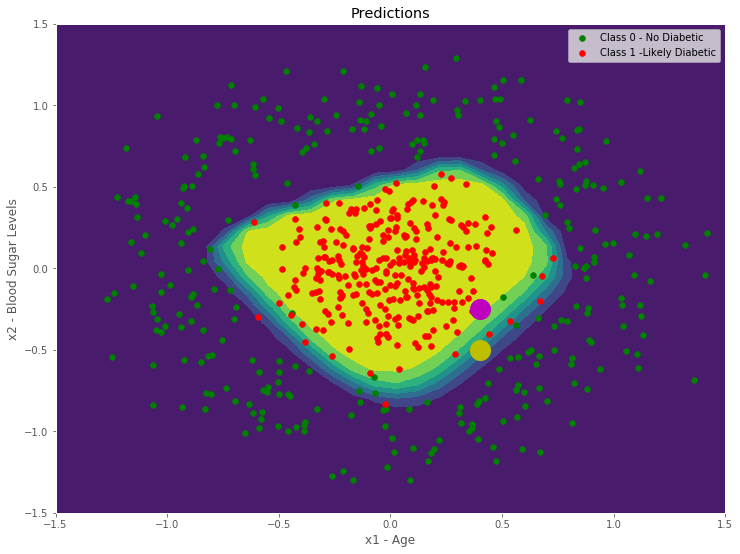

Decision rule: P(positive class)>0.5? class 1: class 0

Point 1 (magenta) -> p(positive class) = 0.94, Predicted class = 1.
point 2 (yellow ) -> p(positive class) = 0.42, Predicted class = 0.


In [13]:
# data points which we want to get a prediction
point1 = torch.Tensor([0.4, -0.25])
point2 = torch.Tensor([0.4, -0.5])

del dataPlot
dataPlot = DataPlot()

dataPlot.plot_Size(12,9)
dataPlot.plot_Decision_Boundary(model,X,y)
dataPlot.xLim(-1.5,1.5)
dataPlot.yLim(-1.5,1.5)    
dataPlot.plot_scatter(X,y,"Predictions")

plt.plot(point1.numpy()[0], point1.numpy()[1],'mo',markersize=20)
plt.plot(point2.numpy()[0], point2.numpy()[1], 'yo',markersize=20)

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)    

dataPlot.plot_show()

point01_pred = model.predict(torch.Tensor(point1).to(device))
point02_pred = model.predict(torch.Tensor(point2).to(device))

print("Decision rule: P(positive class)>0.5? class 1: class 0")
print("\nPoint 1 (magenta) -> p(positive class) = {:0.2f}, Predicted class = {}.".format(point01_pred[0],point01_pred[1]))
print("point 2 (yellow ) -> p(positive class) = {:0.2f}, Predicted class = {}.".format(point02_pred[0],point02_pred[1]))
